#### 07/21 <br> Train, validation, test set 분할하기(joint_trainging.ipynb 참고)

# Continual Learning 데이터 만들기

## 데이터셋 다운로드

우선 데이터셋 다운로드부터 먼저 시작한다. 데이터셋은 미리 업로드된 구글 드라이브 링크로부터 다운로드하게 된다. 업로드된 파일을 내려받기 전에 프로젝트 디렉터리에 `data` 폴더가 있는지 검사하고 그 폴더 안에 각 데이터의 `.zip` 파일이 미리 받아졌는지 먼저 확인하고 (md5 해싱 이용) 파일이 문제가 없으면 압축을 푼다.

In [1]:
import os
import gdown
import hashlib
import zipfile
from datetime import datetime

def generate_save_folder_name(model_name, strategy):
    # 현재의 날짜와 시간
    now = datetime.now()
    # 월과 일을 포맷으로 하는 문자열을 생성
    date_str = now.strftime("%m%d")
    # model_name을 대문자로 바꾸고, date_str 앞에 언더바를 추가
    save_folder_name = model_name.upper() + "_" + strategy.upper() + "_" + date_str

    return save_folder_name


def get_hash(filename):
    with open(filename, "rb") as f:
        data = f.read()
        hash = hashlib.md5(data).hexdigest()
    
    return hash

data_info = {
    "cwru": {"link": "https://drive.google.com/uc?id=1JfnCzisg0wTSkWw_I5sNLcvQMD5mloJy",
             "hash": "a66d9ea53e5b9959829c1d1057abc377"},
    "mfpt": {"link": "https://drive.google.com/uc?id=1HDmX9-v8dV1-53nvM9lSDj-2-S2_Dss5",
             "hash": "fcf44622538307e33503cb7f24fd33d3"},
    "ottawa": {"link": "https://drive.google.com/uc?id=1WelJO5RMFwKoNdumhtW-__PC881fh4J_",
               "hash": "ca0142f52e950b5579985586a6acc96a"
    }
}

os.chdir(os.path.join(globals()['_dh'][0], ".."))

if not os.path.isdir("./data"):
    os.mkdir("./data")

for key in data_info:
    filename = f"./data/{key}.zip"
    if not os.path.isfile(filename):
        gdown.download(data_info[key]["link"], f"./data/{key}.zip")
    else:
        hash = get_hash(filename)
        if hash != data_info[key]["hash"]:
            os.remove(filename)
            gdown.download(data_info[key]["link"], f"./data/{key}.zip")

for key in data_info:
    filename = f"./data/{key}.zip"
    zipfile.ZipFile(filename).extractall("./data/")


In [2]:
from dfb.download import *

dfs = {}

for key in data_info:
    dfs[key] = download_data(f"./data/{key}", key)

File is already existed, use existed file.


In [3]:
from dfb.databuilder import *

# level 1 데이터셋 제작

df_cwru = dfs["cwru"]
df_mfpt = dfs["mfpt"]
df_ottawa = dfs["ottawa"]

data_level1 = {}

df_load1 = df_cwru[(df_cwru["load"] == 1) & (df_cwru["label"] != 999)]
df_load2 = df_cwru[(df_cwru["load"] == 2) & (df_cwru["label"] != 999)]
df_load3 = df_cwru[(df_cwru["load"] == 3) & (df_cwru["label"] != 999)]

data_level1["A"] = build_from_dataframe(df_load1, sample_length=4096, shift=2048)
data_level1["B"] = build_from_dataframe(df_load2, sample_length=4096, shift=2048)
data_level1["C"] = build_from_dataframe(df_load3, sample_length=4096, shift=2048)

# level 2 데이터셋 제작

def set_label_level2(row):
    label_map = {
        "N": 0,
        "B": 1,
        "IR": 2,
        "OR@06": 3
    }
    row["label"] = label_map[row["fault_type"]]
    return row

data_level2 = {}

df_normal = df_cwru[(df_cwru["fault_type"] == "N")]
df_007 = df_cwru[(df_cwru["crack_size"] == "007") & (df_cwru["label"] != 999)]
df_014 = df_cwru[(df_cwru["crack_size"] == "014") & (df_cwru["label"] != 999)]
df_021 = df_cwru[(df_cwru["crack_size"] == "021") & (df_cwru["label"] != 999)]

df_007 = pd.concat(objs=(df_normal, df_007)).apply(set_label_level2, axis="columns")
df_014 = pd.concat(objs=(df_normal, df_014)).apply(set_label_level2, axis="columns")
df_021 = pd.concat(objs=(df_normal, df_021)).apply(set_label_level2, axis="columns")

data_level2["A"] = build_from_dataframe(df_007, sample_length=4096, shift=2048)
data_level2["B"] = build_from_dataframe(df_014, sample_length=4096, shift=2048)
data_level2["C"] = build_from_dataframe(df_021, sample_length=4096, shift=2048)

# level 3 데이터셋 제작

data_level3 = {}

def set_label_level3(row):
    label_map = {
        "N": 0,
        "IR": 1,
        "OR@06": 2,
        "OR": 2
    }
    row["label"] = label_map[row["fault_type"]]
    return row

sample_map = {
    "cwru": {
        "0": 105,
        "1": 35,
        "2": 35
    },
    "mfpt": {
        "0": 140,
        "1": 60,
        "2": 42
    },
    "ottawa": {
        "0": 35,
        "1": 35,
        "2": 35
    }
}

filter_cwru = df_cwru[df_cwru["label"] != 999]
filter_cwru = filter_cwru[(df_cwru["fault_type"] == "N") | (df_cwru["fault_type"] == "IR") | (df_cwru["fault_type"] == "OR@06")].reset_index(drop=True)
filter_mfpt = df_mfpt[(df_mfpt["fault_type"] == "N") | (df_mfpt["fault_type"] == "IR") | (df_mfpt["fault_type"] == "OR")].reset_index(drop=True)
filter_ottawa = df_ottawa[(df_ottawa["fault_type"] == "N") | (df_ottawa["fault_type"] == "IR") | (df_ottawa["fault_type"] == "OR")].reset_index(drop=True)

filter_cwru = filter_cwru.apply(set_label_level3, axis="columns")
filter_mfpt = filter_mfpt.apply(set_label_level3, axis="columns")
filter_ottawa = filter_ottawa.apply(set_label_level3, axis="columns")

data_level3["A"] = bootstrap_from_dataframe(filter_cwru, 4096, 100, False, sample_map["cwru"])
data_level3["B"] = bootstrap_from_dataframe(filter_mfpt, 4096, 100, False, sample_map["mfpt"])
data_level3["C"] = bootstrap_from_dataframe(filter_ottawa, 4096, 100, False, sample_map["ottawa"])

/tmp/ipykernel_226568/582763397.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filter_cwru = filter_cwru[(df_cwru["fault_type"] == "N") | (df_cwru["fault_type"] == "IR") | (df_cwru["fault_type"] == "OR@06")].reset_index(drop=True)


## 데이터 분할 및 데이터로더 래핑

우선 데이터를 분할한다. 훈련, 검증, 테스트 데이터셋을 빠르게 생성하기 위해 dfb의 databuilder 모듈에 구현되어 있는 `train_val_test_split`함수를 이용한다. 우선 각 데이터는 6:2:2로 분할했다. 그리고 numpy array를 PyTorch에서 사용가능한 데이터로더로 만들기 위해서는 추가로 모델 입력의 길이, 모델의 transform (데이터 전처리 함수), 배치 크기, num_worker가 필요하다. 모델 입력의 길이와 transform은 모델에 따라 달라진다. 현재 이 예제에서 구현되어 있는 모델의 입력 길이와 transform은 experiment 모듈의 get_sample_length와 get_transform을 통해 바로 가져올 수 있다. 그렇게 한 후에 dataset 모듈에서 제공하는 `DatasetHandler`클래스를 사용해서 각 level과 experience에 해당하는 numpy array를 `assign` 메소드를 통해 PyTorch 데이터로더로 변환하게 된다.

In [14]:
from dfb.dataset import *
from dfb.processing import *    # Normalize 클래스 사용하기
import experiment
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset

# # (이전) MinMaxScaling을 위한 함수
# def calcMinMax(dataset: Dataset):
#     batch_min, batch_max = None, None
    
#     for data, _ in dataset:
#         sample_min, sample_max = torch.min(data).item(), torch.max(data).item()
        
#         if not batch_min:
#             batch_min = sample_min
#         if not batch_max:
#             batch_max = sample_max
        
#         if sample_min < batch_min:
#             batch_min = sample_min
#         if sample_max > batch_max:
#             batch_max = sample_max

#     return batch_min, batch_max

# # (이전)전체 데이터셋 단위 MinMaxScaling
# class MinMaxScaling:
#     def __init__(self, min, max, scale, symmetric) -> None:
#         self.min = min
#         self.max = max
#         self.scale = scale
#         self.symmetric = symmetric

#     def __call__(self, x):
#         if self.symmetric:
#             return (x - self.min) / (self.max - self.min) * self.scale - (self.scale * 0.5)
#         else:
#             return (x - self.min) / (self.max - self.min) * self.scale

# Sample-wise MinMax Normalize 클래스
class MinMaxScaling:
    def __init__(self, scale=1.0, symmetric=True) -> None:
        self.scale = scale
        self.symmetric = symmetric

    def __call__(self, x):
        x = torch.from_numpy(x)
        min_val = torch.min(x).item()
        max_val = torch.max(x).item()

        if self.symmetric:
            x = (x - min_val) / (max_val - min_val) * self.scale - (self.scale * 0.5)
        else:
            x = (x - min_val) / (max_val - min_val) * self.scale

        return x.numpy()


# # (이전) create_transforms 함수
# def create_transforms(data, label, existing_transforms):
#     # Create a Dataset object
#     dataset = TensorDataset(data, label)
    
#     # Calculate min and max
#     min_val, max_val = calcMinMax(dataset)

#     # Create and return the new transform
#     minmax_transform = MinMaxScaling(min_val, max_val, 1, True)
#     return transforms.Compose([minmax_transform] + existing_transforms.transforms)


def create_transforms(existing_transforms):
    minmax_transform = MinMaxScaling(scale=1, symmetric=True)
    return transforms.Compose([minmax_transform] + existing_transforms.transforms)




In [15]:
# 사용할 모델
model_name = "wdcnn2"

sample_length = experiment.get_sample_length(model_name)
tf_data = experiment.get_transform(model_name) 
tf_data = transforms.Compose(tf_data)

tf_label = NpToTensor()
batch_size = 128
num_worker = 4

data_handler = DatasetHandler()

def process_and_assign(
    data, labels, split_ratios, seed, shuffle, standardize, 
    sample_length, tag, existing_transforms, tf_label, batch_size, num_workers):
    # Split the data
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = \
        train_val_test_split(data, labels, *split_ratios, seed, shuffle, standardize)

    # Create MinMaxScaling transforms
    tf_data_transform = create_transforms(existing_transforms)

    # Assign to data handler
    data_handler.assign(
        X_train, y_train, X_val, y_val, X_test, y_test,
        sample_length, tag, tf_data_transform, tf_label, batch_size, num_workers
    )

tags = ['A', 'B', 'C']
data_levels = [data_level1, data_level2, data_level3]
level_tags = ['1', '2', '3']

for data_level, level_tag in zip(data_levels, level_tags):
    for tag in tags:
        process_and_assign(
            data_level[tag][0], data_level[tag][1], 
            [0.2, 0.2, 0.6], 42, True, True, 
            sample_length, level_tag + tag, tf_data, tf_label, batch_size, num_worker
        )

In [11]:
# 데이터로더 접근해보기
data_handler.dataloaders["1A"]["train"]

#데이터셋 접근해보기
data_handler.dataloaders["1A"]["train"].dataset

#각 단계별 데이터셋 길이 출력해보기
for key in data_handler.dataloaders:
    print('---------'*10)
    print(f"{key}: ", end=' ')
    for phase in data_handler.dataloaders[key]:
        print(f"{phase} dataset length: {len(data_handler.dataloaders[key][phase].dataset)} |", end=' ')
    print()


------------------------------------------------------------------------------------------
1A:  train dataset length: 453 | val dataset length: 152 | test dataset length: 152 | 
------------------------------------------------------------------------------------------
1B:  train dataset length: 453 | val dataset length: 152 | test dataset length: 152 | 
------------------------------------------------------------------------------------------
1C:  train dataset length: 455 | val dataset length: 152 | test dataset length: 152 | 
------------------------------------------------------------------------------------------
2A:  train dataset length: 912 | val dataset length: 304 | test dataset length: 305 | 
------------------------------------------------------------------------------------------
2B:  train dataset length: 912 | val dataset length: 304 | test dataset length: 304 | 
------------------------------------------------------------------------------------------
2C:  train dataset 

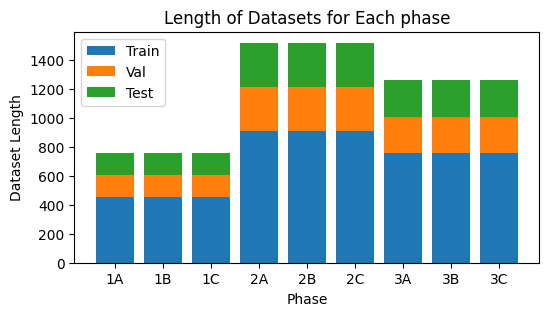

In [12]:
from matplotlib import pyplot as plt
step = []  # 1A, 1B, 1C, 2A, 2B, 2C, 3A, 3B, 3C
train_lengths = []  
val_lengths = []  
test_lengths = []  

for phase in data_handler.dataloaders:
    step.append(phase)
    train_lengths.append(len(data_handler.dataloaders[phase]["train"].dataset))
    val_lengths.append(len(data_handler.dataloaders[phase]["val"].dataset))
    test_lengths.append(len(data_handler.dataloaders[phase]["test"].dataset))

plt.figure(figsize=(6, 3))
train_bars = plt.bar(step, train_lengths, label='Train')
val_bars = plt.bar(step, val_lengths, label='Val', bottom=train_lengths)
test_bars = plt.bar(step, test_lengths, label='Test', bottom=np.array(train_lengths) + np.array(val_lengths))

plt.ylabel('Dataset Length')
plt.xlabel('Phase')
plt.legend()

plt.title('Length of Datasets for Each phase')
plt.show()


756
2
tensor([[-0.0478, -0.0549, -0.0442,  ..., -0.0794, -0.0450, -0.0413]])
torch.Size([1, 2048])


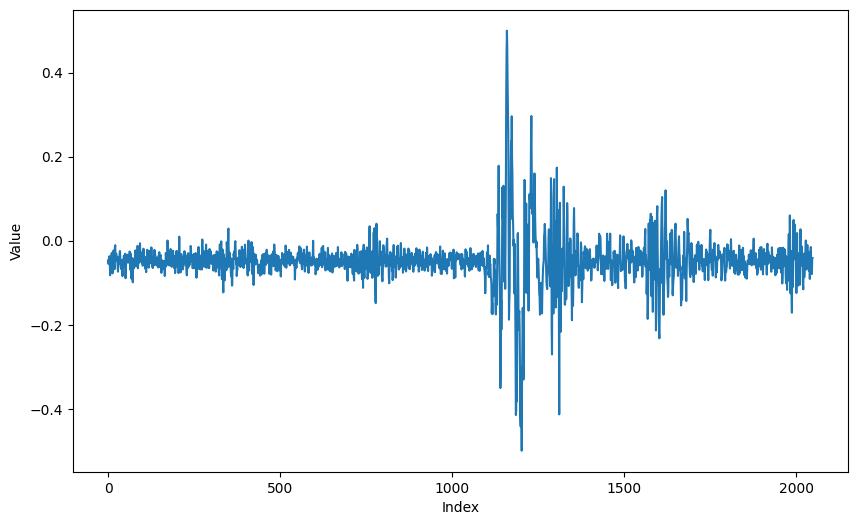

In [16]:
# 3B train 데이터셋의 150번째 데이터 시각화
print(data_handler.dataloaders["3B"]["train"])  
print(len(data_handler.dataloaders["3B"]["train"].dataset))  # 756
print(len(data_handler.dataloaders["3B"]["train"].dataset[100])) # data, label이 있있음
print(data_handler.dataloaders["3B"]["train"].dataset[150][0]) # [0]은 data, [1]은 label
print(data_handler.dataloaders["3B"]["train"].dataset[150][0].shape)



data = data_handler.dataloaders["3B"]["train"].dataset[150][0]

plt.figure(figsize=(10, 6))
plt.plot(data[0])  # Assume the data is 1D after removing the first dimension
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()


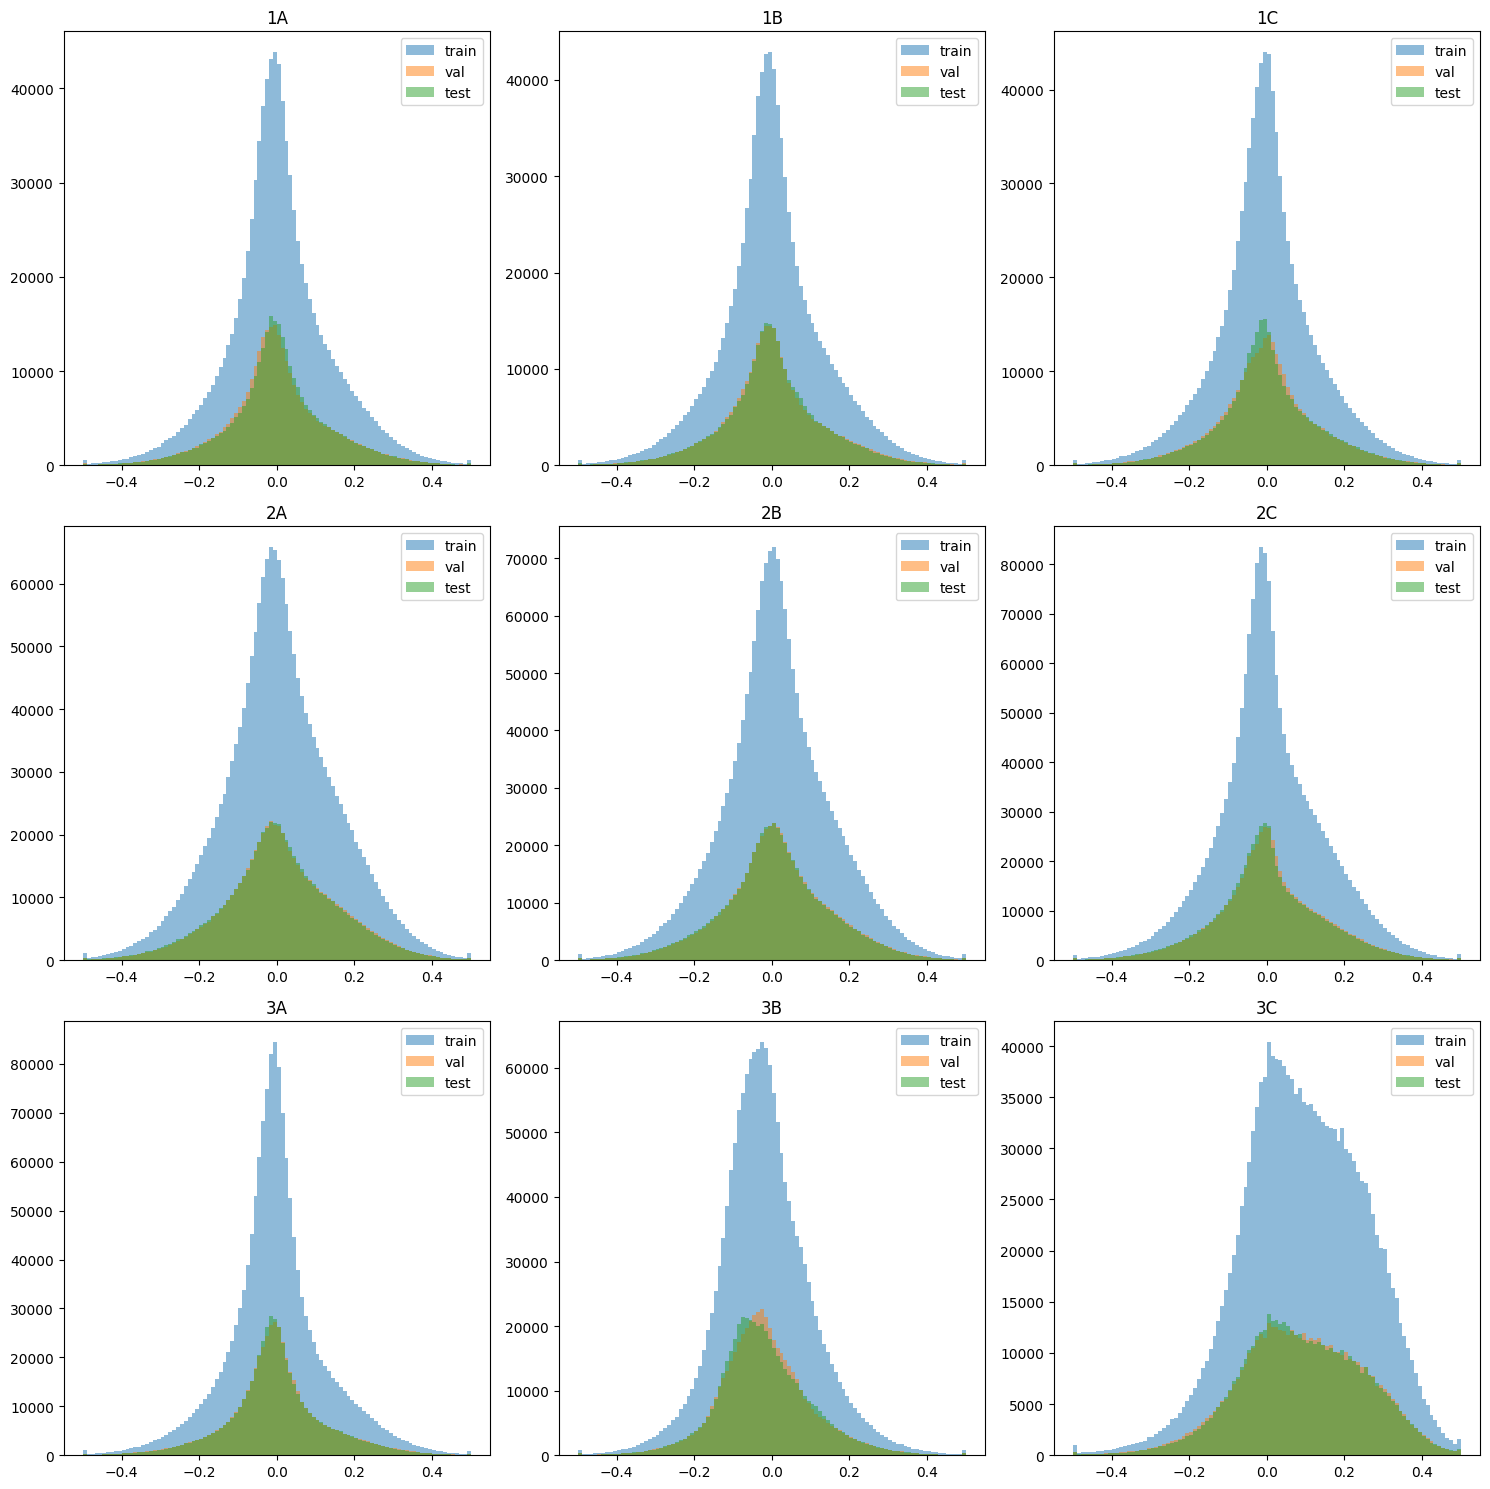

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

for i, step in enumerate(data_handler.dataloaders.keys()): # step은 1A, 1B, 1C, 2A, 2B, 2C, 3A, 3B, 3C
    for split in data_handler.dataloaders[step]: #split은 train, val, test
        data = []
        for sample, _ in data_handler.dataloaders[step][split]: # sample은 data, _는 label
            data.extend(sample.flatten().tolist())
        
        axes[i // 3][i % 3].hist(data, bins=100, alpha=0.5, label=split)
    
    axes[i // 3][i % 3].set_title(step)
    axes[i // 3][i % 3].legend()

plt.tight_layout()
plt.show()


## 모델 가져오기

모델은 아주 간단하게 가져올 수 있다. dfb의 model 폴더에 있는 모델을 아무거나 가져오면 된다.

In [18]:
from dfb.model.wdcnn2 import *

## Continual Learning

여기서부터 continual learning을 해보자!

In [19]:
import avalanche
import json

from avalanche.benchmarks.generators import dataset_benchmark
from avalanche.benchmarks.utils import make_classification_dataset
from torch.optim import SGD, Adam
from torch.nn import CrossEntropyLoss
import torch.nn as nn
from avalanche.training.supervised import JointTraining, Naive, CWRStar, Replay, GDumb, Cumulative, LwF, GEM, EWC
from avalanche.evaluation.metrics import forgetting_metrics, \
accuracy_metrics, loss_metrics, timing_metrics, cpu_usage_metrics, \
confusion_matrix_metrics, disk_usage_metrics
from avalanche.logging import InteractiveLogger, TextLogger
from avalanche.training.plugins import EvaluationPlugin, EarlyStoppingPlugin, ReplayPlugin, \
    CWRStarPlugin, GEMPlugin, LwFPlugin, EWCPlugin



print(avalanche.__version__)

2023-07-25 14:35:53.857900: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-25 14:35:54.397539: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


0.3.1


/home/kyjub/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
def classes_in_level(level):
    if level == 1:
        return 10
    elif level == 2:
        return 4
    elif level == 3:
        return 3

In [21]:
class CLExperiment:
    
    def __init__(self, opt) -> None:

        self.opt = opt
        self.data_handler = data_handler
        self.avg_results = []

    def get_attr(self, name: str):
        if hasattr(self.opt, name):
            return getattr(self.opt, name)
        else:
            return None

    def _make_benchmark_with_level(self, data_handler: DatasetHandler, level: int):

        assert level in [1, 2, 3], "Benchmark level must be one of (1, 2, 3)"

        train_set_list = [data_handler.dataloaders[f'{level}{task}']['train'].dataset for task in ('A', 'B', 'C')]
        test_set_list = [data_handler.dataloaders[f'{level}{task}']['test'].dataset for task in ('A', 'B', 'C')]

        # 'make_classification_dataset' requires that the dataset has an attribute named 'targets'
        for train_set, test_set in zip(train_set_list, test_set_list):
            setattr(train_set, 'targets', train_set.label)
            setattr(test_set, 'targets', test_set.label)

        # AvalancheDatasets with task labels
        train_set_list = [make_classification_dataset(dataset, task_labels=idx) for idx, dataset in enumerate(train_set_list)]
        test_set_list = [make_classification_dataset(dataset, task_labels=idx) for idx, dataset in enumerate(test_set_list)]

        # Compose benchmark
        self.scenario = dataset_benchmark(
            train_set_list,
            test_set_list
        )

    def initialize(self, model, scenario=None, optimizer=None, criterion=None, eval_plugin=None):
        
        self.model = model
        level = self.get_attr('level')

        if not scenario:
            self._make_benchmark_with_level(self.data_handler, level)
        else:
            self.scenario = scenario

        self._initialize_trainig_stuff(self.model, optimizer, criterion)
        self._initialize_cl_strategy(eval_plugin)


    def _initialize_trainig_stuff(self, model: nn.Module, optimizer=None, criterion=None):

        lr = self.get_attr('lr')
        momentum = self.get_attr('momentum')
        weight_decay = self.get_attr('weight_decay')

        if not optimizer:
            optimizer = SGD(
                model.parameters(), lr=lr,
                momentum=momentum, weight_decay=weight_decay
            )
        self.optimizer = optimizer

        if not criterion:
            criterion = CrossEntropyLoss()
        self.criterion = criterion

    def _initialize_cl_strategy(self, eval_plugin):

        if not eval_plugin:
            eval_plugin = EvaluationPlugin(
                accuracy_metrics(epoch=True, experience=True, stream=True),
                loss_metrics(epoch=True, experience=True, stream=True),
                forgetting_metrics(experience=True, stream=True),
                loggers=self._initialize_loggers(self.get_attr('interactive'))
            )

        cl_type = self.get_attr('strategy').lower()

        common_args = dict(
            model=self.model,
            optimizer=self.optimizer,
            criterion=self.criterion,
            train_epochs=self.get_attr('epoch'),
            train_mb_size=self.get_attr('batch_size'),
            eval_mb_size=self.get_attr('batch_size'),
            device=self.get_attr('device'),
            evaluator=eval_plugin
        )

        if cl_type == 'naive':
            self.strategy = Naive(**common_args)
        elif cl_type == 'replay':
            self.strategy = Replay(
                **common_args,
                mem_size=self.get_attr('memory_size')
            )
        elif cl_type == 'joint':
            self.strategy = JointTraining(**common_args)
        elif cl_type == 'cumulative':
            self.strategy = Cumulative(**common_args)

        elif cl_type == 'cwrstar':
            self.strategy = CWRStar(
                cwr_layer_name='conv_layers',   ####### WDCNN2 아키텍처 기준
                **common_args
            )
        elif cl_type == 'gdumb':
            self.strategy = GDumb(
                **common_args
            )
        elif cl_type == 'lwf':
            self.strategy = LwF(
                alpha=0.2,  # Or adjust this parameter as needed
                temperature=1.2,  # Or adjust this parameter as needed
                **common_args
            )
        elif cl_type == 'gem':
            self.strategy = GEM(
                patterns_per_exp=1024,  # 내가 임의로 설정함
                **common_args
            )
        elif cl_type == 'ewc':
            self.strategy = EWC(
                ewc_lambda=0.1,  # 1보다 작게 해야함
                **common_args
            )
        else:
            raise NotImplementedError(f"CL strategy '{cl_type}' has not been implemented yet!!!")


    def _make_param_string(self):
        model_name = type(self.model).__name__
        level = str(self.get_attr('level'))
        strategy = self.get_attr('strategy')
        
        optimizer = type(self.optimizer).__name__
        lr = self.get_attr('lr')
        weight_decay = self.get_attr('weight_decay')
        momentum = self.get_attr('momentum')

        # if strategy.lower() == 'replay':
        #     memory_size = self.get_attr('memory_size') ##### 아래에 {memory_size} 없애야 함
        #     return f'{model_name}_level_{level}_{strategy}_{memory_size}_{optimizer}_lr_{lr}_momentum_{momentum}_l2_reg_{weight_decay}'
        # else:
        #     return f'{model_name}_level_{level}_{strategy}_{optimizer}_lr_{lr}_momentum_{momentum}_l2_reg_{weight_decay}'
        
    
        return f'{model_name}_level_{level}_{strategy}_{optimizer}_lr_{lr}_momentum_{momentum}_l2_reg_{weight_decay}'

    # def _make_log_path(self):
    #     return self._make_param_string() + '.log'

    def _make_log_path(self):
        save_folder = self.get_attr('save_folder_name')
        os.makedirs(save_folder, exist_ok=True)
        log_path = os.path.join(save_folder, self._make_param_string() + '.log')  
        return log_path

    def _initialize_loggers(self, interactive=True, text=True,):
        loggers = []
        if interactive:
            loggers.append(InteractiveLogger())
        if text:
            log_path = self._make_log_path()
            loggers.append(TextLogger(open(log_path, 'a')))
        self.loggers = loggers
        return self.loggers


    def _get_exp_metric_key(self, metric: str, phase: str, task: int, exp: int=None):

        if not exp:
            exp = task

        if metric.lower() == 'acc':
            header = 'Top1_Acc_Exp'
        elif metric.lower() == 'loss':
            header = 'Loss_Exp'
        elif metric.lower() == 'forgetting':
            header = 'ExperienceForgetting'

        return f'{header}/{phase}_phase/test_stream/Task{task:>03d}/Exp{exp:>03d}'


    def _get_metrics_for_joint(self, result):
        metrics = dict()
        avg_accuracy = [result[-1][self._get_exp_metric_key('acc', 'eval', task)] for task in range(3)]
        avg_forgetting = [result[-1][self._get_exp_metric_key('forgetting', 'eval', task)] for task in range(3)]

        metrics['avg_accuracy'] = avg_accuracy
        metrics['avg_forgetting'] = avg_forgetting

        return metrics


    def _get_avg_metrics(self, result):
        if self.get_attr('strategy').lower() == 'joint':
            return self._get_metrics_for_joint()

        num_tasks = len(result)

        metrics = dict()
        avg_accuracy = []
        avg_forgetting = []
        for current in range(num_tasks):
            accuracies = [result[current][self._get_exp_metric_key('acc', 'eval', past)] for past in range(current+1)]
            forgettings = [result[current][self._get_exp_metric_key('forgetting', 'eval', past)] for past in range(current)]

            avg_accuracy.append(np.mean(accuracies))
            if forgettings:
                avg_forgetting.append(np.mean(forgettings))
            else:
                avg_forgetting.append(0)

        metrics['avg_accuracy'] = avg_accuracy
        metrics['avg_forgetting'] = avg_forgetting

        return metrics


    def _get_text_logger(self):

        for logger in self.loggers:
            if isinstance(logger, TextLogger):
                return logger
        return None
    

    def _append_results(self, results):
        avg_metrics = self._get_avg_metrics(results)
        self.avg_results.append(avg_metrics)
        
        print(avg_metrics)

        text_logger = self._get_text_logger()
        if text_logger:
            print(avg_metrics, file=text_logger.file, flush=True)

    def save_results(self, filename=None):
        if not filename:
            filename = self._make_param_string() + '_results.json'
        
        save_folder = self.get_attr('save_folder_name')
        os.makedirs(save_folder, exist_ok=True)
        
        filepath = os.path.join(save_folder, filename)
        json.dump(self.avg_results, open(filepath, 'w'), indent=4)


    def get_best_result(self):

        final_avg_acc = [metrics['avg_accuracy'][-1] for metrics in self.avg_results]
        best_result_idx = np.argmax(final_avg_acc)
        
        return best_result_idx, self.avg_results[best_result_idx]


    def _execute_joint_training(self):

        results = []

        self.strategy.train(self.scenario.train_stream)
        results.append(self.strategy.eval(self.scenario.test_stream))
        
        self._append_results(results)


    def _execute(self):

        results = []
        
        for exp in self.scenario.train_stream:
            self.strategy.train(exp)
            results.append(self.strategy.eval(self.scenario.test_stream))

        self._append_results(results)


    def execute(self, exec_id=0):
        for logger in self.loggers:
            if isinstance(logger, TextLogger):
                print(f"Start execution {exec_id}!!!", file=logger.file, flush=True)

        if self.get_attr('strategy') == 'joint':
            self._execute_joint_training()
        else:
            self._execute()

        

In [29]:
import argparse

parser = argparse.ArgumentParser()

parser.add_argument(
    '--level',
    type=int,
    choices=[1, 2, 3],
    default=1
)
parser.add_argument(
    '--repeat',
    type=int,
    default=50
)
parser.add_argument(
    '--strategy',
    type=str,
    default='Naive'
)
parser.add_argument(
    '--lr',
    type=float,
    default=0.01, 
)
parser.add_argument(
    '--momentum',
    type=float,
    default=0
)
parser.add_argument(
    '--l2',
    type=float,
    dest='weight_decay',
    default=0.01,
)
parser.add_argument(
    '--device',
    choices=['cuda', 'cpu'],
    default='cuda',
)
parser.add_argument(
    '--batch-size',
    type=int,
    default=64,
)
parser.add_argument(
    '--epoch',
    type=int,
    default=100,  # 50에서 100으로 변경
)
parser.add_argument(
    '--memory-size',
    type=int,
    default=200,
)
parser.add_argument(
    '--interactive',
    type=bool,
    default=False
)
parser.add_argument(
    '--save_folder_name',
    type=str,
    default='.'
)

_StoreAction(option_strings=['--save_folder_name'], dest='save_folder_name', nargs=None, const=None, default='.', type=<class 'str'>, choices=None, required=False, help=None, metavar=None)

In [30]:
def start_experiment(opt):

    cl_experiment = CLExperiment(opt)

    repeat = cl_experiment.get_attr('repeat')
    level = cl_experiment.get_attr('level')

    for idx in range(repeat):
        model = WDCNN2(n_classes=classes_in_level(level))

        cl_experiment.initialize(model) 
        cl_experiment.execute(idx)

    cl_experiment.save_results()


In [31]:
strategies = ['replay', 'cumulative', 'gdumb', 'lwf', 'gem', 'ewc']
strategies = ['replay', 'lwf', 'gem', 'ewc']
levels = ['1', '2', '3']

In [32]:
from tqdm import tqdm

for level in tqdm(levels, desc='Levels'):
    for strategy in tqdm(strategies, desc='Strategies'):
        print(f'### Level {level}, Strategy {strategy} ###')
        opt_list = [
            '--level', str(level),
            '--strategy', strategy,
            '--save_folder_name', generate_save_folder_name(model_name, strategy),
        ]
        opt = parser.parse_args(opt_list)
        start_experiment(opt)


Levels:   0%|          | 0/3 [00:00<?, ?it/s]

### Level 1, Strategy replay ###
{'avg_accuracy': [0.9407894736842105, 0.9802631578947368, 0.9846491228070176], 'avg_forgetting': [0, -0.03947368421052633, -0.019736842105263164]}
{'avg_accuracy': [0.9539473684210527, 0.9868421052631579, 0.9824561403508772], 'avg_forgetting': [0, -0.0328947368421052, -0.006578947368421073]}
{'avg_accuracy': [0.9671052631578947, 0.9769736842105263, 0.9824561403508772], 'avg_forgetting': [0, -0.006578947368421129, -5.551115123125783e-17]}
{'avg_accuracy': [0.9276315789473685, 0.9769736842105263, 0.9824561403508771], 'avg_forgetting': [0, -0.05263157894736836, -0.02960526315789469]}
{'avg_accuracy': [0.9473684210526315, 0.9802631578947368, 0.9802631578947368], 'avg_forgetting': [0, -0.019736842105263164, -0.0032894736842105643]}
{'avg_accuracy': [0.9078947368421053, 0.9769736842105263, 0.9671052631578947], 'avg_forgetting': [0, -0.06578947368421051, -0.01315789473684209]}
{'avg_accuracy': [0.9671052631578947, 0.9605263157894737, 0.9692982456140351], 'avg_

{'avg_accuracy': [0.9671052631578947, 0.9703947368421053, 0.9824561403508772], 'avg_forgetting': [0, 0.0, -0.006578947368421073]}
### Level 1, Strategy cumulative ###
{'avg_accuracy': [0.9605263157894737, 0.9868421052631579, 0.9890350877192983], 'avg_forgetting': [0, -0.02631578947368418, -0.019736842105263164]}
{'avg_accuracy': [0.8881578947368421, 0.993421052631579, 0.9956140350877193], 'avg_forgetting': [0, -0.11184210526315785, -0.05592105263157898]}
{'avg_accuracy': [0.9736842105263158, 0.9802631578947368, 0.9978070175438596], 'avg_forgetting': [0, -0.006578947368421018, -0.023026315789473673]}
{'avg_accuracy': [0.9605263157894737, 0.9473684210526315, 0.9824561403508772], 'avg_forgetting': [0, 0.013157894736842146, -0.03947368421052638]}
{'avg_accuracy': [0.9407894736842105, 0.9736842105263157, 0.9934210526315789], 'avg_forgetting': [0, -0.02631578947368418, -0.029605263157894746]}
{'avg_accuracy': [0.9671052631578947, 0.9901315789473684, 0.9824561403508772], 'avg_forgetting': [0,

{'avg_accuracy': [0.8618421052631579, 0.9835526315789473, 0.9802631578947368], 'avg_forgetting': [0, -0.11842105263157898, -0.05921052631578955]}
### Level 1, Strategy lwf ###
{'avg_accuracy': [0.9671052631578947, 0.9769736842105263, 0.9671052631578947], 'avg_forgetting': [0, -0.013157894736842146, 0.019736842105263108]}
{'avg_accuracy': [0.9342105263157895, 0.9144736842105263, 0.9824561403508771], 'avg_forgetting': [0, 0.019736842105263164, -0.059210526315789436]}
{'avg_accuracy': [0.9473684210526315, 0.9671052631578947, 0.9780701754385964], 'avg_forgetting': [0, 0.0, -5.551115123125783e-17]}
{'avg_accuracy': [0.9407894736842105, 0.9111842105263157, 0.9320175438596491], 'avg_forgetting': [0, 0.019736842105263164, 0.013157894736842035]}
{'avg_accuracy': [0.9210526315789473, 0.9703947368421053, 0.9583333333333334], 'avg_forgetting': [0, -0.03947368421052633, 0.01315789473684209]}
{'avg_accuracy': [0.9144736842105263, 0.9901315789473684, 0.975877192982456], 'avg_forgetting': [0, -0.07236

{'avg_accuracy': [0.9473684210526315, 0.950657894736842, 0.9912280701754387], 'avg_forgetting': [0, 0.013157894736842035, -0.03289473684210531]}
### Level 1, Strategy gem ###
{'avg_accuracy': [0.9605263157894737, 0.9835526315789473, 0.9802631578947368], 'avg_forgetting': [0, -0.006578947368421018, -0.003289473684210509]}
{'avg_accuracy': [0.9013157894736842, 0.9901315789473684, 0.9846491228070176], 'avg_forgetting': [0, -0.0921052631578948, -0.03947368421052638]}
{'avg_accuracy': [0.9342105263157895, 0.9769736842105263, 0.9671052631578947], 'avg_forgetting': [0, -0.046052631578947345, -0.01315789473684209]}
{'avg_accuracy': [0.9473684210526315, 0.9802631578947368, 0.9934210526315791], 'avg_forgetting': [0, -0.026315789473684292, -0.026315789473684237]}
{'avg_accuracy': [0.9078947368421053, 0.9802631578947368, 0.9846491228070176], 'avg_forgetting': [0, -0.06578947368421051, -0.032894736842105254]}
{'avg_accuracy': [0.9539473684210527, 0.9671052631578947, 0.9539473684210527], 'avg_forget

{'avg_accuracy': [0.9802631578947368, 0.993421052631579, 0.9890350877192983], 'avg_forgetting': [0, -0.006578947368421018, 0.003289473684210509]}
### Level 1, Strategy ewc ###
{'avg_accuracy': [0.9342105263157895, 0.9802631578947368, 0.9342105263157895], 'avg_forgetting': [0, -0.0328947368421052, 0.03947368421052633]}
{'avg_accuracy': [0.9539473684210527, 0.9802631578947368, 0.956140350877193], 'avg_forgetting': [0, -0.013157894736842035, 0.03618421052631582]}
{'avg_accuracy': [0.9473684210526315, 0.9769736842105263, 0.9583333333333334], 'avg_forgetting': [0, -0.019736842105263164, 0.02960526315789469]}
{'avg_accuracy': [0.9671052631578947, 0.9901315789473684, 0.9736842105263158], 'avg_forgetting': [0, -0.019736842105263164, 0.019736842105263164]}
{'avg_accuracy': [0.9078947368421053, 0.9572368421052632, 0.9649122807017544], 'avg_forgetting': [0, -0.0328947368421052, -0.006578947368421018]}
{'avg_accuracy': [0.9605263157894737, 0.9868421052631579, 0.9561403508771931], 'avg_forgetting':

Levels:  33%|███▎      | 1/3 [1:43:29<3:26:59, 6209.53s/it]

{'avg_accuracy': [0.9539473684210527, 0.986842105263158, 0.956140350877193], 'avg_forgetting': [0, -0.019736842105263164, 0.042763157894736836]}


### Level 2, Strategy replay ###
{'avg_accuracy': [1.0, 1.0, 0.9967105263157895], 'avg_forgetting': [0, 0.0, 0.004934210526315763]}
{'avg_accuracy': [1.0, 0.9983552631578947, 0.9912280701754387], 'avg_forgetting': [0, 0.0, 0.011513157894736836]}
{'avg_accuracy': [1.0, 1.0, 0.9780701754385964], 'avg_forgetting': [0, 0.0, 0.032894736842105254]}
{'avg_accuracy': [1.0, 1.0, 0.9879385964912281], 'avg_forgetting': [0, 0.0, 0.01809210526315791]}
{'avg_accuracy': [1.0, 0.9983552631578947, 0.9912316652286455], 'avg_forgetting': [0, 0.0, 0.011507765314926643]}
{'avg_accuracy': [1.0, 1.0, 0.9967105263157895], 'avg_forgetting': [0, 0.0, 0.004934210526315763]}
{'avg_accuracy': [1.0, 1.0, 0.9945175438596491], 'avg_forgetting': [0, 0.0, 0.008223684210526327]}
{'avg_accuracy': [1.0, 1.0, 0.974780701754386], 'avg_forgetting': [0, 0.0, 0.03782894736842107]}
{'avg_accuracy': [1.0, 1.0, 0.9868421052631579], 'avg_forgetting': [0, 0.0, 0.019736842105263164]}
{'avg_accuracy': [1.0, 1.0, 1.0], 'avg_forgetting

{'avg_accuracy': [1.0, 1.0, 0.9769736842105262], 'avg_forgetting': [0, 0.0, 0.03453947368421051]}
### Level 2, Strategy cumulative ###
{'avg_accuracy': [1.0, 1.0, 1.0], 'avg_forgetting': [0, 0.0, 0.0]}
{'avg_accuracy': [1.0, 1.0, 0.9956140350877193], 'avg_forgetting': [0, 0.0, 0.006578947368421073]}
{'avg_accuracy': [1.0, 1.0, 1.0], 'avg_forgetting': [0, 0.0, 0.0]}
{'avg_accuracy': [1.0, 1.0, 0.9846742881794651], 'avg_forgetting': [0, 0.0, 0.02134383088869718]}
{'avg_accuracy': [1.0, 1.0, 1.0], 'avg_forgetting': [0, 0.0, 0.0]}
{'avg_accuracy': [1.0, 1.0, 1.0], 'avg_forgetting': [0, 0.0, 0.0]}
{'avg_accuracy': [1.0, 0.9589408973252804, 1.0], 'avg_forgetting': [0, 0.0360655737704918, -0.023026315789473673]}
{'avg_accuracy': [1.0, 1.0, 1.0], 'avg_forgetting': [0, 0.0, 0.0]}
{'avg_accuracy': [1.0, 1.0, 1.0], 'avg_forgetting': [0, 0.0, 0.0]}
{'avg_accuracy': [1.0, 1.0, 1.0], 'avg_forgetting': [0, 0.0, 0.0]}
{'avg_accuracy': [1.0, 1.0, 0.9967105263157895], 'avg_forgetting': [0, 0.0, 0.004934

{'avg_accuracy': [1.0, 1.0, 1.0], 'avg_forgetting': [0, 0.0, 0.0]}
### Level 2, Strategy lwf ###
{'avg_accuracy': [1.0, 0.9688524590163934, 0.9035087719298245], 'avg_forgetting': [0, 0.06229508196721312, 0.14473684210526316]}
{'avg_accuracy': [1.0, 0.9475355910267472, 0.8991587575496117], 'avg_forgetting': [0, 0.10163934426229504, 0.14961712683347717]}
{'avg_accuracy': [1.0, 0.944256902502157, 0.871836353178027], 'avg_forgetting': [0, 0.1081967213114754, 0.1906007333908542]}
{'avg_accuracy': [1.0, 0.9950657894736843, 0.9265350877192983], 'avg_forgetting': [0, 0.0, 0.10526315789473689]}
{'avg_accuracy': [1.0, 0.9508196721311475, 0.8291343111878056], 'avg_forgetting': [0, 0.09836065573770492, 0.23491695427092318]}
{'avg_accuracy': [1.0, 1.0, 0.8872052056370435], 'avg_forgetting': [0, 0.0, 0.16919219154443488]}
{'avg_accuracy': [1.0, 0.9753936583261433, 0.9210742018981882], 'avg_forgetting': [0, 0.03934426229508192, 0.11345448662640206]}
{'avg_accuracy': [1.0, 0.9950765746333046, 0.938596

{'avg_accuracy': [1.0, 0.9295028041415013, 0.8773044291055507], 'avg_forgetting': [0, 0.13770491803278684, 0.1823986194995686]}
### Level 2, Strategy gem ###
{'avg_accuracy': [1.0, 1.0, 0.9835526315789473], 'avg_forgetting': [0, 0.0, 0.024671052631578927]}
{'avg_accuracy': [1.0, 1.0, 0.9912280701754387], 'avg_forgetting': [0, 0.0, 0.01315789473684209]}
{'avg_accuracy': [1.0, 0.9983606557377049, 0.980277538107564], 'avg_forgetting': [0, 0.003278688524590123, 0.029583692838653974]}
{'avg_accuracy': [1.0, 0.9983606557377049, 0.9769736842105262], 'avg_forgetting': [0, 0.003278688524590123, 0.03453947368421051]}
{'avg_accuracy': [1.0, 1.0, 0.9879385964912281], 'avg_forgetting': [0, 0.0, 0.01809210526315791]}
{'avg_accuracy': [1.0, 0.9950819672131148, 0.9967141213689962], 'avg_forgetting': [0, 0.00983606557377048, 0.00492881794650557]}
{'avg_accuracy': [1.0, 0.9983606557377049, 0.9890350877192983], 'avg_forgetting': [0, 0.003278688524590123, 0.016447368421052655]}
{'avg_accuracy': [1.0, 1.0,

{'avg_accuracy': [1.0, 1.0, 0.9945175438596491], 'avg_forgetting': [0, 0.0, 0.008223684210526327]}
### Level 2, Strategy ewc ###
{'avg_accuracy': [1.0, 0.904880284728214, 0.8806370434282428], 'avg_forgetting': [0, 0.1672131147540984, 0.16753127696289905]}
{'avg_accuracy': [1.0, 0.919672131147541, 0.8729687949381651], 'avg_forgetting': [0, 0.16065573770491803, 0.1905468075927524]}
{'avg_accuracy': [1.0, 0.9754098360655737, 0.8992773943054356], 'avg_forgetting': [0, 0.049180327868852514, 0.15108390854184645]}
{'avg_accuracy': [1.0, 0.9491803278688524, 0.8805867126833476], 'avg_forgetting': [0, 0.10163934426229504, 0.17911993097497847]}
{'avg_accuracy': [1.0, 0.9016393442622951, 0.8784584411849296], 'avg_forgetting': [0, 0.19672131147540983, 0.18231233822260567]}
{'avg_accuracy': [1.0, 0.9426229508196722, 0.8510425654299684], 'avg_forgetting': [0, 0.11475409836065575, 0.22343615185504745]}
{'avg_accuracy': [1.0, 0.9655737704918033, 0.8861194995685936], 'avg_forgetting': [0, 0.068852459016

Levels:  67%|██████▋   | 2/3 [5:21:59<2:51:08, 10268.53s/it]

{'avg_accuracy': [1.0, 0.9229508196721312, 0.8662927811331608], 'avg_forgetting': [0, 0.15409836065573768, 0.20056082830025884]}


### Level 3, Strategy replay ###
{'avg_accuracy': [0.996031746031746, 0.9821428571428572, 0.6507936507936508], 'avg_forgetting': [0, -0.003968253968253954, 0.2896825396825397]}
{'avg_accuracy': [0.996031746031746, 0.9742063492063493, 0.9484126984126985], 'avg_forgetting': [0, 0.007936507936507908, 0.041666666666666685]}
{'avg_accuracy': [1.0, 0.9682539682539683, 0.9417989417989419], 'avg_forgetting': [0, 0.007936507936507908, 0.049603174603174593]}
{'avg_accuracy': [1.0, 0.9722222222222222, 0.958994708994709], 'avg_forgetting': [0, 0.019841269841269882, 0.0317460317460318]}
{'avg_accuracy': [0.996031746031746, 0.9702380952380952, 0.9417989417989419], 'avg_forgetting': [0, 0.015873015873015928, 0.051587301587301626]}
{'avg_accuracy': [1.0, 0.9642857142857143, 0.9351851851851851], 'avg_forgetting': [0, 0.011904761904761862, 0.05555555555555558]}
{'avg_accuracy': [1.0, 0.9623015873015873, 0.9470899470899471], 'avg_forgetting': [0, 0.007936507936507908, 0.031746031746031744]}
{'avg_accurac

{'avg_accuracy': [1.0, 0.9702380952380952, 0.9563492063492064], 'avg_forgetting': [0, 0.011904761904761862, 0.029761904761904767]}
### Level 3, Strategy cumulative ###
{'avg_accuracy': [1.0, 0.9880952380952381, 0.9735449735449735], 'avg_forgetting': [0, 0.0, 0.013888888888888895]}
{'avg_accuracy': [1.0, 0.9801587301587302, 0.978835978835979], 'avg_forgetting': [0, 0.0, -0.001984126984126977]}
{'avg_accuracy': [1.0, 0.9781746031746033, 0.9735449735449735], 'avg_forgetting': [0, 0.003968253968253954, 0.005952380952380987]}
{'avg_accuracy': [0.9920634920634921, 0.9801587301587302, 0.9629629629629629], 'avg_forgetting': [0, -0.003968253968253954, 0.009920634920634941]}
{'avg_accuracy': [1.0, 0.9821428571428572, 0.9828042328042329], 'avg_forgetting': [0, 0.0, -0.003968253968253954]}
{'avg_accuracy': [0.996031746031746, 0.9900793650793651, 0.9298941798941799], 'avg_forgetting': [0, 0.0, 0.0357142857142857]}
{'avg_accuracy': [0.996031746031746, 0.9742063492063492, 0.9722222222222222], 'avg_fo

{'avg_accuracy': [1.0, 0.9702380952380952, 0.9814814814814815], 'avg_forgetting': [0, 0.003968253968253954, -0.015873015873015872]}
### Level 3, Strategy lwf ###
{'avg_accuracy': [1.0, 0.8432539682539683, 0.8015873015873017], 'avg_forgetting': [0, 0.2222222222222222, 0.2222222222222222]}
{'avg_accuracy': [1.0, 0.8412698412698413, 0.8267195767195767], 'avg_forgetting': [0, 0.23412698412698407, 0.18849206349206343]}
{'avg_accuracy': [1.0, 0.8392857142857143, 0.8187830687830688], 'avg_forgetting': [0, 0.23412698412698407, 0.2103174603174603]}
{'avg_accuracy': [1.0, 0.8333333333333333, 0.8201058201058201], 'avg_forgetting': [0, 0.2658730158730159, 0.20833333333333337]}
{'avg_accuracy': [0.9801587301587301, 0.8134920634920635, 0.7314814814814815], 'avg_forgetting': [0, 0.2142857142857142, 0.3015873015873016]}
{'avg_accuracy': [1.0, 0.8115079365079365, 0.7698412698412698], 'avg_forgetting': [0, 0.2698412698412699, 0.25793650793650796]}
{'avg_accuracy': [1.0, 0.8253968253968254, 0.79761904761

{'avg_accuracy': [0.996031746031746, 0.8571428571428571, 0.8293650793650794], 'avg_forgetting': [0, 0.20238095238095244, 0.18452380952380948]}
### Level 3, Strategy gem ###
{'avg_accuracy': [1.0, 0.9543650793650793, 0.8941798941798941], 'avg_forgetting': [0, 0.015873015873015928, 0.06349206349206354]}
{'avg_accuracy': [1.0, 0.9682539682539683, 0.8664021164021164], 'avg_forgetting': [0, 0.003968253968253954, 0.10515873015873017]}
{'avg_accuracy': [1.0, 0.9543650793650793, 0.9087301587301587], 'avg_forgetting': [0, 0.0357142857142857, 0.08134920634920634]}
{'avg_accuracy': [1.0, 0.9662698412698413, 0.8902116402116401], 'avg_forgetting': [0, 0.023809523809523836, 0.08333333333333337]}
{'avg_accuracy': [0.996031746031746, 0.9623015873015873, 0.8214285714285715], 'avg_forgetting': [0, 0.003968253968253954, 0.11706349206349209]}
{'avg_accuracy': [0.996031746031746, 0.9623015873015872, 0.9007936507936508], 'avg_forgetting': [0, 0.023809523809523836, 0.0932539682539682]}
{'avg_accuracy': [0.99

{'avg_accuracy': [0.996031746031746, 0.9702380952380952, 0.9007936507936508], 'avg_forgetting': [0, 0.0, 0.07738095238095233]}
### Level 3, Strategy ewc ###
{'avg_accuracy': [0.996031746031746, 0.8293650793650793, 0.6825396825396827], 'avg_forgetting': [0, 0.29761904761904767, 0.44047619047619047]}
{'avg_accuracy': [0.996031746031746, 0.8412698412698413, 0.7420634920634921], 'avg_forgetting': [0, 0.27380952380952384, 0.34523809523809523]}
{'avg_accuracy': [1.0, 0.8234126984126984, 0.7579365079365079], 'avg_forgetting': [0, 0.31746031746031744, 0.3373015873015873]}
{'avg_accuracy': [0.996031746031746, 0.8611111111111112, 0.7142857142857143], 'avg_forgetting': [0, 0.23015873015873012, 0.3888888888888889]}
{'avg_accuracy': [1.0, 0.8690476190476191, 0.6798941798941799], 'avg_forgetting': [0, 0.23412698412698407, 0.45436507936507936]}
{'avg_accuracy': [1.0, 0.8492063492063493, 0.6402116402116401], 'avg_forgetting': [0, 0.2579365079365079, 0.4900793650793651]}
{'avg_accuracy': [0.99603174603

Levels: 100%|██████████| 3/3 [8:11:48<00:00, 9836.13s/it]   

{'avg_accuracy': [0.996031746031746, 0.8313492063492063, 0.6785714285714285], 'avg_forgetting': [0, 0.3055555555555556, 0.4523809523809524]}


In [33]:
# strategies = ['naive', 'replay', 'cumulative', 'gdumb', 'lwf', 'gem', 'ewc']

In [34]:
import matplotlib.pyplot as plt

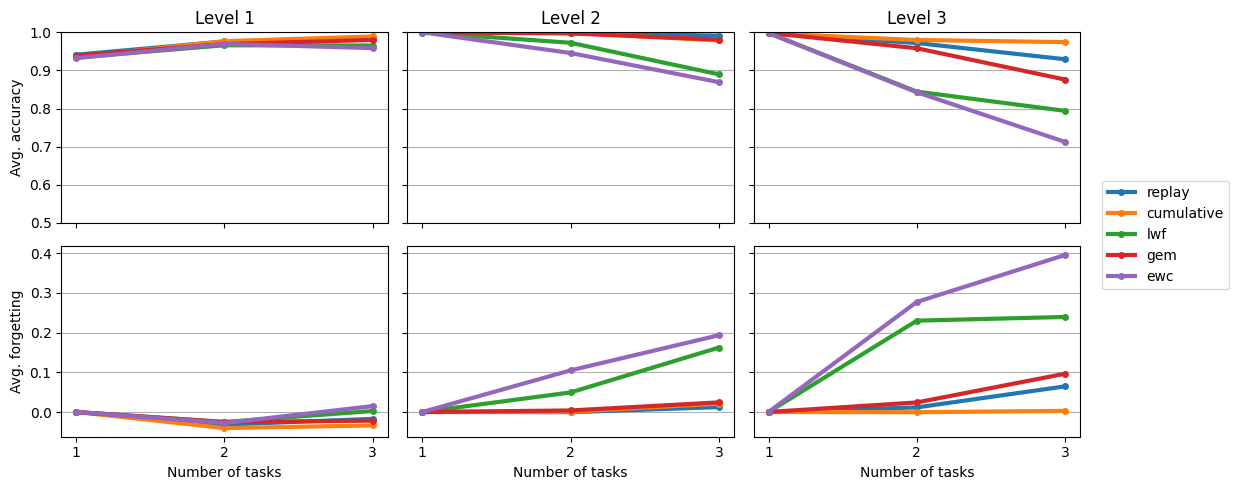

In [36]:
fig, axes = plt.subplots(2, 3, sharex='all', sharey='row', figsize=(11, 5))
for level in range(3):

    results = [json.load(open(f"WDCNN2_{strategy.upper()}_0725/WDCNN2_level_{level+1}_{strategy}_SGD_lr_0.01_momentum_0_l2_reg_0.01_results.json", 'r')) for strategy in strategies]

    avg_accs = []
    avg_forgetting = []
    for result in results:
        avg_accs.append([metric['avg_accuracy'] for metric in result])
        avg_forgetting.append([metric['avg_forgetting'] for metric in result])
    
    mean_accs = np.mean(avg_accs, axis=1)
    mean_forgetting = np.mean(avg_forgetting, axis=1)

    avg_plot_args = []
    forgetting_plot_args = []
    x = ['1', '2', '3']
    for idx, strat in enumerate(strategies):
        avg_plot_args.append(x)
        avg_plot_args.append(mean_accs[idx])
        avg_plot_args.append('-o')

        forgetting_plot_args.append(x)
        forgetting_plot_args.append(mean_forgetting[idx])
        forgetting_plot_args.append('-o')

    axes[0][level].plot(*avg_plot_args, markersize=4, linewidth=3)
    axes[0][level].set_title(f"Level {level+1}")
    if level == 0:
        axes[0][level].set_ylabel("Avg. accuracy")
    axes[0][level].set_ylim(0.5, 1.)
    axes[0][level].grid(True, axis='y')

    axes[1][level].plot(*forgetting_plot_args, markersize=4, linewidth=3)
    if level == 0:
        axes[1][level].set_ylabel("Avg. forgetting")
    axes[1][level].set_xlabel("Number of tasks")
    axes[1][level].grid(True, axis='y')
    
fig.legend(strategies, loc='center left', bbox_to_anchor=(1, 0.52))
plt.tight_layout()
plt.savefig(f'strategy_results_graph.png', dpi=300, bbox_inches='tight')

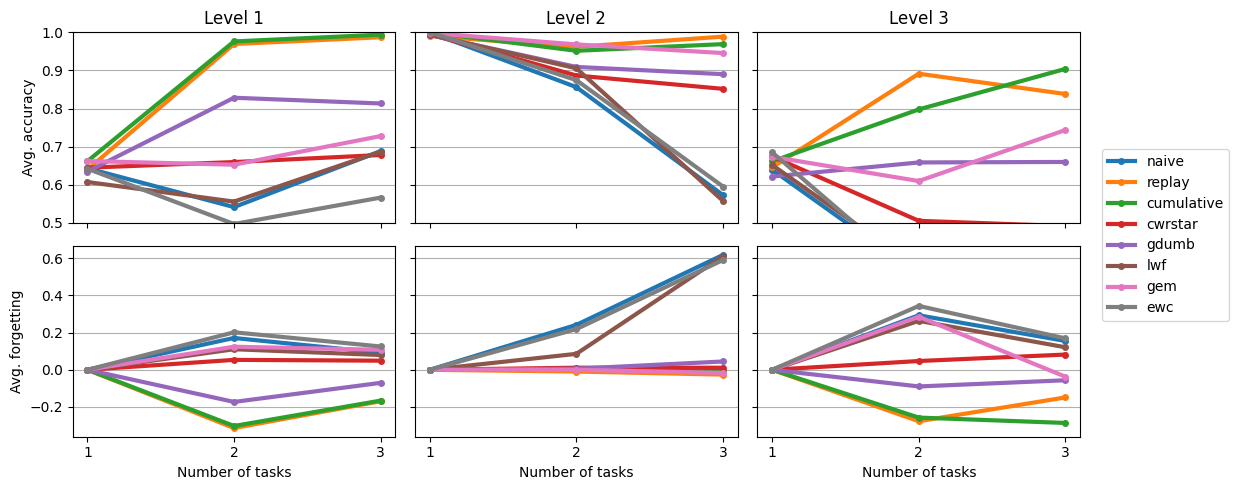

In [24]:
strategies = ['naive', 'replay', 'cumulative', 'cwrstar', 'gdumb', 'lwf', 'gem', 'ewc']
fig, axes = plt.subplots(2, 3, sharex='all', sharey='row', figsize=(11, 5))
for level in range(3):

    results = [json.load(open(f"WDCNN2_{strategy.upper()}_0723/WDCNN2_level_{level+1}_{strategy}_SGD_lr_0.01_momentum_0_l2_reg_0.01_results.json", 'r')) for strategy in strategies]

    avg_accs = []
    avg_forgetting = []
    for result in results:
        avg_accs.append([metric['avg_accuracy'] for metric in result])
        avg_forgetting.append([metric['avg_forgetting'] for metric in result])
    
    mean_accs = np.mean(avg_accs, axis=1)
    mean_forgetting = np.mean(avg_forgetting, axis=1)

    avg_plot_args = []
    forgetting_plot_args = []
    x = ['1', '2', '3']
    for idx, strat in enumerate(strategies):
        avg_plot_args.append(x)
        avg_plot_args.append(mean_accs[idx])
        avg_plot_args.append('-o')

        forgetting_plot_args.append(x)
        forgetting_plot_args.append(mean_forgetting[idx])
        forgetting_plot_args.append('-o')

    axes[0][level].plot(*avg_plot_args, markersize=4, linewidth=3)
    axes[0][level].set_title(f"Level {level+1}")
    if level == 0:
        axes[0][level].set_ylabel("Avg. accuracy")
    axes[0][level].set_ylim(0.5, 1.)
    axes[0][level].grid(True, axis='y')

    axes[1][level].plot(*forgetting_plot_args, markersize=4, linewidth=3)
    if level == 0:
        axes[1][level].set_ylabel("Avg. forgetting")
    axes[1][level].set_xlabel("Number of tasks")
    axes[1][level].grid(True, axis='y')
    
fig.legend(strategies, loc='center left', bbox_to_anchor=(1, 0.52))
plt.tight_layout()
plt.savefig(f'strategy_results_graph.png', dpi=300, bbox_inches='tight')


In [21]:
cumulative_results = json.load(open("WDCNN_level_3_Cumulative_SGD_lr_0.01_momentum_0_l2_reg_0.01_results.json", 'r'))
naive_results = json.load(open("WDCNN_level_3_Naive_SGD_lr_0.01_momentum_0_l2_reg_0.01_results.json", 'r'))
replay_results = json.load(open("WDCNN_level_3_Replay_SGD_lr_0.01_momentum_0_l2_reg_0.01_results.json", 'r'))

In [22]:
cumulative_avg_acc = np.array([metric['avg_accuracy'] for metric in cumulative_results])
naive_avg_acc = np.array([metric['avg_accuracy'] for metric in naive_results])
replay_avg_acc = np.array([metric['avg_accuracy'] for metric in replay_results])

In [23]:
mean_cum, std_cum = np.mean(cumulative_avg_acc, axis=0), np.std(cumulative_avg_acc, axis=0)
mean_naive, std_naive = np.mean(naive_avg_acc, axis=0), np.std(naive_avg_acc, axis=0)
mean_re, std_re = np.mean(replay_avg_acc, axis=0), np.std(replay_avg_acc, axis=0)

In [25]:
### 일단 바꿈
memory_sizes = ['25', '50', '75']

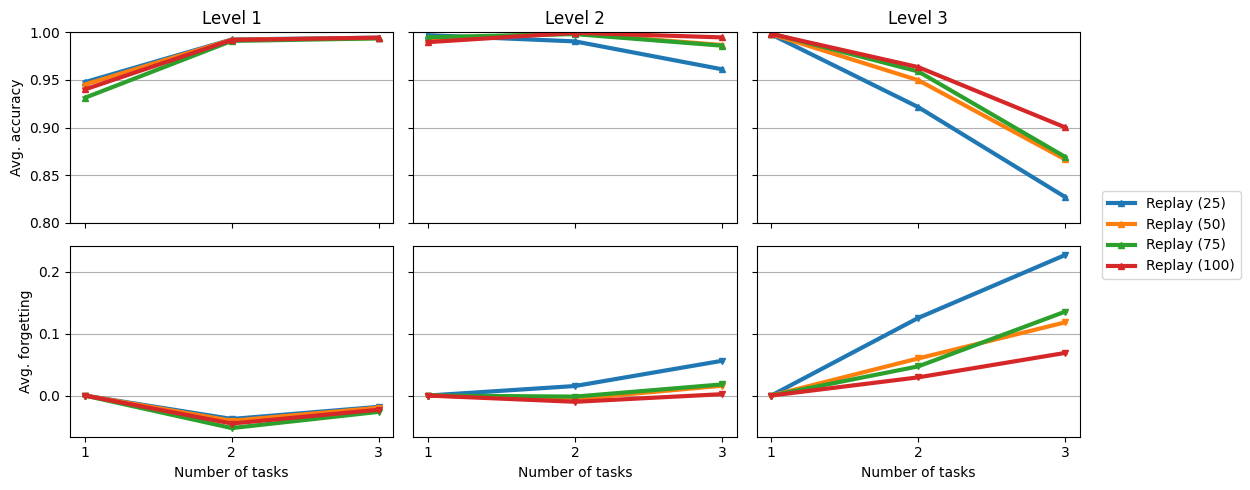

In [29]:
fig, axes = plt.subplots(2, 3, sharex='all', sharey='row', figsize=(11, 5))
for level in range(3):

    results = [json.load(open(f"WDCNN_level_{level+1}_Replay_{memory}_SGD_lr_0.01_momentum_0_l2_reg_0.01_results.json", 'r')) for memory in memory_sizes]
    results.append(json.load(open(f"WDCNN_level_{level+1}_Replay_SGD_lr_0.01_momentum_0_l2_reg_0.01_results.json", 'r')))  # 메모리 100

    avg_accs = []
    avg_forgetting = []
    for result in results:
        avg_accs.append([metric['avg_accuracy'] for metric in result])
        avg_forgetting.append([metric['avg_forgetting'] for metric in result])
    
    mean_accs = np.mean(avg_accs, axis=1)
    mean_forgetting = np.mean(avg_forgetting, axis=1)

    avg_plot_args = []
    forgetting_plot_args = []
    x = ['1', '2', '3']
    for idx, mem_size in enumerate(['25', '50', '75', '100']):
        avg_plot_args.append(x)
        avg_plot_args.append(mean_accs[idx])
        avg_plot_args.append('-^')

        forgetting_plot_args.append(x)
        forgetting_plot_args.append(mean_forgetting[idx])
        forgetting_plot_args.append('-v')

    axes[0][level].plot(*avg_plot_args, markersize=4, linewidth=3)
    axes[0][level].set_title(f"Level {level+1}")
    if level == 0:
        axes[0][level].set_ylabel("Avg. accuracy")
    axes[0][level].set_ylim(0.8, 1.)
    axes[0][level].grid(True, axis='y')

    axes[1][level].plot(*forgetting_plot_args, markersize=4, linewidth=3)
    if level == 0:
        axes[1][level].set_ylabel("Avg. forgetting")
    axes[1][level].set_xlabel("Number of tasks")
    axes[1][level].grid(True, axis='y')
    
fig.legend([f'Replay ({size})' for size in [25, 50, 75, 100]], loc='center left', bbox_to_anchor=(1, 0.52))
plt.tight_layout()
plt.savefig(f'replay_results_graph.png', dpi=300, bbox_inches='tight')

In [30]:
x = ['1', '2', '3']

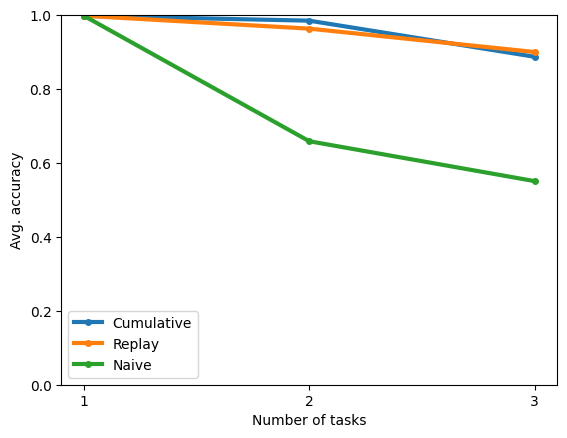

In [31]:
plt.plot(x, mean_cum, '-o', x, mean_re, '-o', x, mean_naive, '-o', markersize=4, linewidth=3)
plt.ylabel("Avg. accuracy")
plt.ylim(0., 1.)
plt.xlabel("Number of tasks")
plt.legend(["Cumulative", "Replay", "Naive"])

In [32]:
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu

In [33]:
mannwhitneyu(replay_avg_acc[:, 2], cumulative_avg_acc[:, 2])

MannwhitneyuResult(statistic=1393.5, pvalue=0.32418845118821493)

((array([-2.20385432, -1.83293478, -1.61402323, -1.45296849, -1.32267759,
         -1.21163342, -1.113805  , -1.02561527, -0.94475674, -0.86964726,
         -0.79915021, -0.73241807, -0.66879925, -0.6077796 , -0.54894415,
         -0.49195112, -0.43651377, -0.38238727, -0.32935914, -0.27724191,
         -0.2258675 , -0.17508277, -0.12474591, -0.07472335, -0.02488719,
          0.02488719,  0.07472335,  0.12474591,  0.17508277,  0.2258675 ,
          0.27724191,  0.32935914,  0.38238727,  0.43651377,  0.49195112,
          0.54894415,  0.6077796 ,  0.66879925,  0.73241807,  0.79915021,
          0.86964726,  0.94475674,  1.02561527,  1.113805  ,  1.21163342,
          1.32267759,  1.45296849,  1.61402323,  1.83293478,  2.20385432]),
  array([0.98412698, 0.99206349, 0.99206349, 0.99603175, 0.99603175,
         0.99603175, 0.99603175, 0.99603175, 0.99603175, 0.99603175,
         0.99603175, 0.99603175, 0.99603175, 0.99603175, 0.99603175,
         0.99603175, 0.99603175, 0.99603175, 0.9960

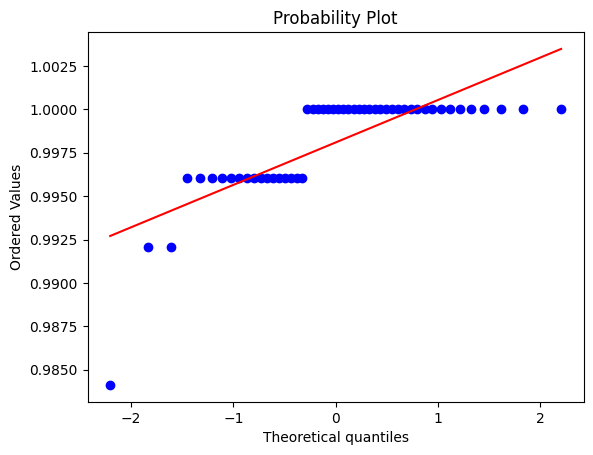

In [34]:
fig, ax = plt.subplots()
probplot(cumulative_avg_acc[:, 0], plot=ax)

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  5., 24., 19.]),
 array([0.5 , 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 ,
        0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71,
        0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82,
        0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93,
        0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  ]),
 <BarContainer object of 50 artists>)

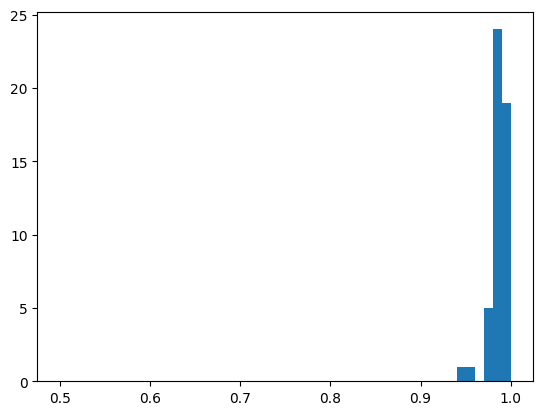

In [35]:
plt.hist(cumulative_avg_acc[:, 1], bins=50, range=[0.5, 1])